# BINF TP3 - Algorithmes d'alignement par paire

Dans ce TP nous allons manipuler les algorithmes d'alignement par paire.

# Exercice 0 - Echauffement

Q1. Donnez le score de la superposition :

|       |       |
| :---: | :---: |
x       | ATGTCATGA---TAC |
y       | AT--CTAAATGTTAC |


étant donne le schéma d'évaluation :

|       | A     | T     | G     | C     |
| :---: | :---: | :---: | :---: | :---: |
| **A** | 1     | -1    | -1    | -1    |
| **T** | -1    | 1     | -1    | -1    |
| **G** | -1    | -1    | 1     | -1    |
| **C** | -1    | -1    | -1    | 1     |

et

$\gamma(g) = 0.5 |g| + 0.5$

```markdown
0.5
```

Q2. Alignez les séquences suivantes avec l'algorithme de Levenshtein :  x = ATG et y = ACTG.

```markdown
x = A-TG et y = ACTG
```

Q3.	Alignez les séquences suivantes avec l'algorithme de Needleman-Wunsch global x = TAT et y = ATGAC en considérant le schéma d'évaluation suivant

|       | A       | T       | G       | C     |
| :---: | :---:   | :---:   | :---:   | :---: |
| **A** | 1       | -0.5    | -0.5    | -0.5  |
| **T** | -0.5    | 1       | -0.5    | -0.5  |
| **G** | -0.5    | -0.5    | 1       | -0.5  |
| **C** | -0.5    | -0.5    | -0.5    | 1     |

et

$\gamma(g) = 0.5 |g|$


```markdown
x = -T-AT et y = ATGAC
```

Q4. Alignez les séquences suivantes avec l'algorithme de Smith-Waterman x = TTGG y = ATGAC en utilisant le schéma d'évaluation de la question précédente.


```markdown
x = TTGG et y = T-GG
```

# Exercice 1 : Algorithme de Levenshtein - version récursive

Q1. Ecrivez une fonction

levenshtein(x: str, y: str) -> int

qui retourne la distance de Levenshtein entre les séquences x et y en utilisant la  version récursive de l'algorithme.

In [3]:
def levenshtein(x, y):
    if not x:
        return len(y)
    if not y:
        return len(x)
    if x[0] == y[0]:
        return levenshtein(x[1:], y[1:])
    else:
        return 1 + min(levenshtein(x[1:], y),
                       levenshtein(x, y[1:]),
                       levenshtein(x[1:], y[1:]))


Q2. Vous pouvez tester votre code sur les exemples suivants:


*   $L('CCAG', 'CA') = 2$
*   $L('CCGT', 'CGTCA') = 3$
*   $L(AY678264^*, OQ870305^*) = 310$

$^*$ ids genbank de deux sequences.

In [6]:
print(levenshtein('CCAG', 'CA'))
print(levenshtein('CCGT', 'CGTCA'))
# print(levenshtein('ATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGCACATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAGGGCGAGGGCGAGGGCCGCCCCTACGAGGGCACCCAGACCGCCAAGCTGAAGGTGACCAAGGGTGGCCCCCTGCCCTTCGCCTGGGACATCCTGTCCCCTCAGTTCATGTACGGCTCCAAGGCCTACGTGAAGCACCCCGCCGACATCCCCGACTACTTGAAGCTGTCCTTCCCCGAGGGCTTCAAGTGGGAGCGCGTGATGAACTTCGAGGACGGCGGCGTGGTGACCGTGACCCAGGACTCCTCCCTGCAGGACGGCGAGTTCATCTACAAGGTGAAGCTGCGCGGCACCAACTTCCCCTCCGACGGCCCCGTAATGCAGAAGAAGACCATGGGCTGGGAGGCCTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTAA',
#                   'ATGGTCTCCTTCAAATCTCTCCTAGTTCTCTGTTGCGCTGCCCTTGGGGCATTCGCTACGAAGAGAATGAGTAAAGGAGAAGAACTTTTCACTGGAGTTGTCCCAATTCTTGTTGAATTAGATGGTGATGTTAATGGGCACAAATTTTCTGTCAGTGGAGAGGGTGAAGGTGATGCAACATACGGAAAACTTACCCTTAAATTTATTTGCACTACTGGAAAACTACCTGTTCCATGGCCAACACTTGTCACTACTTTCACCTATGGTGTTCAATGCTTTTCAAGATACCCAGATCATATGAAGCGGCACGACTTCTTCAAGAGCGCCATGCCTGAGGGATACGTGCAGGAGAGGACCATCTTCTTCAAAGACGACGGGAACTACAAGACACGTGCTGAAGTCAAGTTTGAGGGAGACACCCTCGTCAACAGGATCGAGCTTAAGGGAATCGATTTCAAGGAGGACGGAAACATCCTCGGCCACAAGTTGGAATACAACTACAACTCCCACAACGTATACATCATGGCCGACAAGCAAAAGAACGGCATCAAAGCCAACTTCAAGACCCGCCACAACATCGAAGACGGCGGCGTGCAACTCGCTGATCATTATCAACAAAATACTCCAATTGGCGATGGCCCTGTCCTTTTACCAGACAACCATTACCTGTCCACACAATCTGCCCTTTCGAAAGATCCCAACGAAAAGAGAGACCACATGGTCCTTCTTGAGTTTGTAACAGCTGCTGGGATTACACATGGCATGGATGAACTATACAAATAA')

2
3


# Exercice 2 : Algorithme de Smith-Waterman - version itérative

Q1. Ecrivez la fonction

sw_fwd(x: str, y: str, cmap: dict, sigma: array, (go, ge): list) -> (array, array)

qui construit les matrices $S$ et $B$ en utilisant l'algorithme de Smith-Waterman pour aligner les séquences x et y suivant le schéma d'évaluation donné par la matrice de substitution $\Sigma$ et la fonction d'évaluation des trous $\gamma(n)= g_o + g_e \times n$. Le dictionnaire cmap donne la position des différents nucléotides dans la matrice $\Sigma$. La fonction retourne la paire de matrices de score $S$ et de retour $B$.

In [31]:
import numpy as np

def sw_fwd(x, y, cmap, sigma, gaps):
    m, n = len(x), len(y)
    S = np.zeros((m + 1, n + 1))
    B = np.zeros((m + 1, n + 1), dtype=int)
    go, ge = gaps
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            xi, yj = cmap[x[i - 1]], cmap[y[j - 1]]
            match = S[i - 1, j - 1] + sigma[xi, yj]
            delete = max(S[k, j] - (go + ge * (i - k)) for k in range(i))
            insert = max(S[i, l] - (go + ge * (j - l)) for l in range(j))
            S[i, j] = max(0, match, delete, insert)
            if S[i, j] == match:
                B[i, j] = 1
            elif S[i, j] == delete:
                B[i, j] = 3
            elif S[i, j] == insert:
                B[i, j] = 2
            else:
                B[i, j] = 0

    return S, B


Q2. Ecrivez la fonction

sw_bwd(x: str, y: str, S: array, B: array) -> (str, str, float)

qui effectue l'etape de retour de l'algorithme de Smith-Waterman etant donné les séquences $x$ et $y$ et les matrices de score $S$ et de retour $B$. La fonction retourne un tuple contenant les alignements des séquences x et y et le score de l'alignement.

In [32]:
import numpy as np
def sw_bwd(x, y, S, B):
    n, m = len(x), len(y)
    i, j = np.unravel_index(S.argmax(), S.shape)
    align_x, align_y = "", ""
    score = S[i, j]

    while B[i, j] != 0:
        if B[i, j] == 1:
            align_x = x[i - 1] + align_x
            align_y = y[j - 1] + align_y
            i -= 1
            j -= 1
        elif B[i, j] == 2:
            align_x = x[i - 1] + align_x
            align_y = "-" + align_y
            i -= 1
        elif B[i, j] == 3:
            align_x = "-" + align_x
            align_y = y[j - 1] + align_y
            j -= 1

    return align_x, align_y, score


Q3. Vous pouvez tester votre code en utilisant le schéma d'évaluation suivant :

In [33]:
cmap = {"A": 0, "T": 1, "G": 2, "C": 3}
m = np.array([[1, -0.5, -0.5, -0.5],
              [-0.5, 1, -0.5, -0.5],
              [-0.5, -0.5, 1, -0.5],
              [-0.5, -0.5, -0.5, 1]])
go = 0
ge = 0.5

*   $SW('TCGC', 'CTTAG')$ retourne un score de $1.5$ à la position $(3,5)$ et l'alignement
```markdown
x: TCG
y: TAG
```

In [34]:
S, B = sw_fwd('TCGC', 'CTTAG', cmap, m, (go, ge))
# print(S, B)
print(sw_bwd('TCGC', 'CTTAG', S, B))

('TCG', 'TAG', 1.5)


*   $SW(AY678264^*, OQ870305^*)$ retourne un score de $342.1$ à la position $(708,717)$ et l'alignement

In [ ]:
from IPython.display import HTML
HTML("<table width='300px' align='left' style='font-family:Courier New'><tr><th>x:</th><th nowrap='nowrap'>ATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGC-A-CATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAG---GGCGAGGGCGAGGGC--CGCC-CCTACGAGGGCACCCAGACCGC-CAAGCTGAAGGTG-ACCA-AGG---G-TGGCC---CCCT-GCCCTTCGCCT-GGGA-CATCCTGTCC--C--C-T-CAGTTCATGT-A-CGGCT-CCAAGGCCTACGTG-A--AGCAC--C--C--C--G-CCGACATCCCCG-A--CTAC-T--TGAAGCTG-TCCTTC--C--C-----CGA-GG--GCTTCAAGTGGGAGCG-CGTGATGAACTTCGAGGACGGCGGCGTGGTG-ACCG--T-GA-C-CCAGGAC-TC--CTCCCTGCAGGACGGCGAGTTCATCTACAAGGTG---AAGCTGCGCGGCACCAACTTCCCCT-CCGACGGCCCCGTA-ATGCA-GAAGAAGACCATGGGCTG--GGA-GGCCTCCTCCGAGCGGATGTACCCCGAGGA-CGGCGCC-CTGAAGGGCGAGATCAAGCAGA-GGCTGAAGC-TGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACA-AGGCCAAGAAG-CCCGTGCAGCTGCCCGGC-GCCTACAACGTCAACATCAAGT-TG----GA-CATCACCTCCCACAACGAGGA-CTAC-A-C-CA---T-C-G-TGGAACAGTACG-AACGCGCCGAGGGCCGCCACTCCAC-CGGCGGCATGGACGAGCTGTACAAG</th></tr><tr><th>y:</th><th>ATGGTGAGCAAGGGCGAGGA-G----C-T-G--TTCA-C-CGG-GGTGGTGCCCATCCTGGT-CGAGC-TGGACGGCGACGTAAACGGCCACAAGTTC-AG--CGTGTCCGGCGAGGGCGAGGGCGATGCCACCTAC---GGCAAGCTGACC-CTGAAG-TTCATTTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCC-AC-CCTCGTGACCACCCTGACCTACGGCGTGCAGTGC-T-TCAGCCGCTACCCCGACC-ACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGC-GCACCATCTTCTTCAAGGACGACGGCAACTACAAGA-CCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGC-A--ACATC--C-TGGGGCACAAGCTG-G-AGTA-CAACTACAACAGCC-ACAACGTC-TATAT-CATG--GCCGA-CAA--GCAGAAGAACGG-CA--T-C-A-AGG-TGAACTTC-AAGATC--CGCCAC--AA---C---ATCGAG--GACGGC---AGCGTGCAGCTCGCCGACCACTACCA-GC--A-G--AACACC-CC--CATCGGCGACG--GCCCCGTGCTGCTGCCCGACAACC-ACTACCTGAGCACCCAGTCCGCCCTGAGCAA-A-GACCC-CAACGAGAAGC-GCGATCACATGGTCCTGCTGG---AGTTCGTGAC-CGCC----GCCGGGA-T-CACTC-TCGGCATGGACGAGCTGTACAAG</th></tr></table>")

x:,ATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGC-A-CATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAG---GGCGAGGGCGAGGGC--CGCC-CCTACGAGGGCACCCAGACCGC-CAAGCTGAAGGTG-ACCA-AGG---G-TGGCC---CCCT-GCCCTTCGCCT-GGGA-CATCCTGTCC--C--C-T-CAGTTCATGT-A-CGGCT-CCAAGGCCTACGTG-A--AGCAC--C--C--C--G-CCGACATCCCCG-A--CTAC-T--TGAAGCTG-TCCTTC--C--C-----CGA-GG--GCTTCAAGTGGGAGCG-CGTGATGAACTTCGAGGACGGCGGCGTGGTG-ACCG--T-GA-C-CCAGGAC-TC--CTCCCTGCAGGACGGCGAGTTCATCTACAAGGTG---AAGCTGCGCGGCACCAACTTCCCCT-CCGACGGCCCCGTA-ATGCA-GAAGAAGACCATGGGCTG--GGA-GGCCTCCTCCGAGCGGATGTACCCCGAGGA-CGGCGCC-CTGAAGGGCGAGATCAAGCAGA-GGCTGAAGC-TGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACA-AGGCCAAGAAG-CCCGTGCAGCTGCCCGGC-GCCTACAACGTCAACATCAAGT-TG----GA-CATCACCTCCCACAACGAGGA-CTAC-A-C-CA---T-C-G-TGGAACAGTACG-AACGCGCCGAGGGCCGCCACTCCAC-CGGCGGCATGGACGAGCTGTACAAG
y:,ATGGTGAGCAAGGGCGAGGA-G----C-T-G--TTCA-C-CGG-GGTGGTGCCCATCCTGGT-CGAGC-TGGACGGCGACGTAAACGGCCACAAGTTC-AG--CGTGTCCGGCGAGGGCGAGGGCGATGCCACCTAC---GGCAAGCTGACC-CTGAAG-TTCATTTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCC-AC-CCTCGTGACCACCCTGACCTACGGCGTGCAGTGC-T-TCAGCCGCTACCCCGACC-ACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGC-GCACCATCTTCTTCAAGGACGACGGCAACTACAAGA-CCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGC-A--ACATC--C-TGGGGCACAAGCTG-G-AGTA-CAACTACAACAGCC-ACAACGTC-TATAT-CATG--GCCGA-CAA--GCAGAAGAACGG-CA--T-C-A-AGG-TGAACTTC-AAGATC--CGCCAC--AA---C---ATCGAG--GACGGC---AGCGTGCAGCTCGCCGACCACTACCA-GC--A-G--AACACC-CC--CATCGGCGACG--GCCCCGTGCTGCTGCCCGACAACC-ACTACCTGAGCACCCAGTCCGCCCTGAGCAA-A-GACCC-CAACGAGAAGC-GCGATCACATGGTCCTGCTGG---AGTTCGTGAC-CGCC----GCCGGGA-T-CACTC-TCGGCATGGACGAGCTGTACAAG


In [29]:
# S, B = sw_fwd('ATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGCACATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAGGGCGAGGGCGAGGGCCGCCCCTACGAGGGCACCCAGACCGCCAAGCTGAAGGTGACCAAGGGTGGCCCCCTGCCCTTCGCCTGGGACATCCTGTCCCCTCAGTTCATGTACGGCTCCAAGGCCTACGTGAAGCACCCCGCCGACATCCCCGACTACTTGAAGCTGTCCTTCCCCGAGGGCTTCAAGTGGGAGCGCGTGATGAACTTCGAGGACGGCGGCGTGGTGACCGTGACCCAGGACTCCTCCCTGCAGGACGGCGAGTTCATCTACAAGGTGAAGCTGCGCGGCACCAACTTCCCCTCCGACGGCCCCGTAATGCAGAAGAAGACCATGGGCTGGGAGGCCTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTAA',
#               'ATGGTCTCCTTCAAATCTCTCCTAGTTCTCTGTTGCGCTGCCCTTGGGGCATTCGCTACGAAGAGAATGAGTAAAGGAGAAGAACTTTTCACTGGAGTTGTCCCAATTCTTGTTGAATTAGATGGTGATGTTAATGGGCACAAATTTTCTGTCAGTGGAGAGGGTGAAGGTGATGCAACATACGGAAAACTTACCCTTAAATTTATTTGCACTACTGGAAAACTACCTGTTCCATGGCCAACACTTGTCACTACTTTCACCTATGGTGTTCAATGCTTTTCAAGATACCCAGATCATATGAAGCGGCACGACTTCTTCAAGAGCGCCATGCCTGAGGGATACGTGCAGGAGAGGACCATCTTCTTCAAAGACGACGGGAACTACAAGACACGTGCTGAAGTCAAGTTTGAGGGAGACACCCTCGTCAACAGGATCGAGCTTAAGGGAATCGATTTCAAGGAGGACGGAAACATCCTCGGCCACAAGTTGGAATACAACTACAACTCCCACAACGTATACATCATGGCCGACAAGCAAAAGAACGGCATCAAAGCCAACTTCAAGACCCGCCACAACATCGAAGACGGCGGCGTGCAACTCGCTGATCATTATCAACAAAATACTCCAATTGGCGATGGCCCTGTCCTTTTACCAGACAACCATTACCTGTCCACACAATCTGCCCTTTCGAAAGATCCCAACGAAAAGAGAGACCACATGGTCCTTCTTGAGTTTGTAACAGCTGCTGGGATTACACATGGCATGGATGAACTATACAAATAA',
#               cmap, m, (go, ge))
# print(S, B)
# print(sw_bwd('ATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGCACATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAGGGCGAGGGCGAGGGCCGCCCCTACGAGGGCACCCAGACCGCCAAGCTGAAGGTGACCAAGGGTGGCCCCCTGCCCTTCGCCTGGGACATCCTGTCCCCTCAGTTCATGTACGGCTCCAAGGCCTACGTGAAGCACCCCGCCGACATCCCCGACTACTTGAAGCTGTCCTTCCCCGAGGGCTTCAAGTGGGAGCGCGTGATGAACTTCGAGGACGGCGGCGTGGTGACCGTGACCCAGGACTCCTCCCTGCAGGACGGCGAGTTCATCTACAAGGTGAAGCTGCGCGGCACCAACTTCCCCTCCGACGGCCCCGTAATGCAGAAGAAGACCATGGGCTGGGAGGCCTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTAA',
#              'ATGGTCTCCTTCAAATCTCTCCTAGTTCTCTGTTGCGCTGCCCTTGGGGCATTCGCTACGAAGAGAATGAGTAAAGGAGAAGAACTTTTCACTGGAGTTGTCCCAATTCTTGTTGAATTAGATGGTGATGTTAATGGGCACAAATTTTCTGTCAGTGGAGAGGGTGAAGGTGATGCAACATACGGAAAACTTACCCTTAAATTTATTTGCACTACTGGAAAACTACCTGTTCCATGGCCAACACTTGTCACTACTTTCACCTATGGTGTTCAATGCTTTTCAAGATACCCAGATCATATGAAGCGGCACGACTTCTTCAAGAGCGCCATGCCTGAGGGATACGTGCAGGAGAGGACCATCTTCTTCAAAGACGACGGGAACTACAAGACACGTGCTGAAGTCAAGTTTGAGGGAGACACCCTCGTCAACAGGATCGAGCTTAAGGGAATCGATTTCAAGGAGGACGGAAACATCCTCGGCCACAAGTTGGAATACAACTACAACTCCCACAACGTATACATCATGGCCGACAAGCAAAAGAACGGCATCAAAGCCAACTTCAAGACCCGCCACAACATCGAAGACGGCGGCGTGCAACTCGCTGATCATTATCAACAAAATACTCCAATTGGCGATGGCCCTGTCCTTTTACCAGACAACCATTACCTGTCCACACAATCTGCCCTTTCGAAAGATCCCAACGAAAAGAGAGACCACATGGTCCTTCTTGAGTTTGTAACAGCTGCTGGGATTACACATGGCATGGATGAACTATACAAATAA',
#              S, B))

# Exercice 3 : Distribution des scores d’alignement pour des séquences aléatoires

Pour tester si un alignement reflète une réelle similarité biologique, on va évaluer la distribution des scores d’alignement pour des paires de séquences aléatoires.

Q1. En considérant deux séquences aléatoires de même taille N, où chaque nucléotide apparaît avec une probabilité uniforme de ¼, calculer le score moyen attendu pour une superposition sans trou dans le cas où une identité vaut +1 et une différence vaut 0.

```markdown
N / 4
```

Q2. La question précédente peut se resoudre analytiquement car on ne considère pas de trou. Pour étendre le résultat precedent à un alignement avec trous, on va se baser sur la simulation de séquences aleatoires.

Générez $R$ paires de séquences aléatoires  de tailles $N$ avec des probabilitées uniformes d'apparition de nucléotides $p_A = p_T = p_G = p_C = $ ¼. Affichez sous forme de violinplots les distribution des scores d'alignements entre chaque paire, obtenu par :
  1. un alignement sans trou (cf. Q1) ;
  2. un alignement local via Smith-Waterman (utilisez le code de l'exercice précédent)

Utilisez le schéma d'évaluation suivant :

In [37]:
rmap = {"A": 0, "T": 1, "G": 2, "C": 3}
sigma = np.array([[1, -0.5, -0.5, -0.5],
                  [-0.5, 1, -0.5, -0.5],
                  [-0.5, -0.5, 1, -0.5],
                  [-0.5, -0.5, -0.5, 1]])
go =0
ge = 0.5

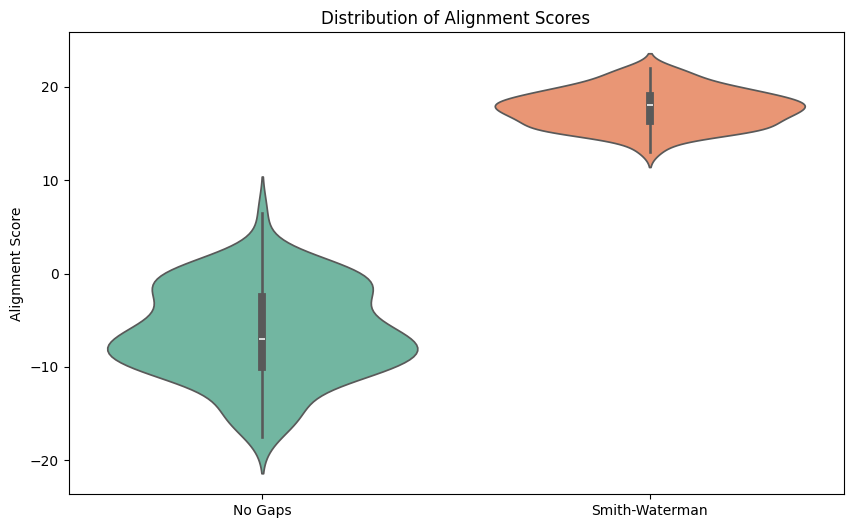

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def generate_random_sequence(length):
    nucleotides = ["A", "T", "G", "C"]
    return ''.join(np.random.choice(nucleotides) for _ in range(length))

def calculate_alignment_score_no_gaps(seq1, seq2, sigma, cmap):
    score = 0
    for i in range(len(seq1)):
        score += sigma[cmap[seq1[i]], cmap[seq2[i]]]
    return score

R = 100
N = 50

scores_no_gaps = []
scores_sw = []

for _ in range(R):
    seq1 = generate_random_sequence(N)
    seq2 = generate_random_sequence(N)

    scores_no_gaps.append(calculate_alignment_score_no_gaps(seq1, seq2, sigma, cmap))

    S, B = sw_fwd(seq1, seq2, cmap, sigma, (go, ge))
    _, _, sw_score = sw_bwd(seq1, seq2, S, B)
    scores_sw.append(sw_score)

plt.figure(figsize=(10, 6))
sns.violinplot(data=[scores_no_gaps, scores_sw], palette="Set2")
plt.xticks([0, 1], ['No Gaps', 'Smith-Waterman'])
plt.ylabel('Alignment Score')
plt.title('Distribution of Alignment Scores')
plt.show()


Q3. Qu'observez-vous ?

```markdown
La distribution sans trous est plus large car il est plus compliqué d'aligner les séquences sans les trous,
donc le score en devient moins grand
```

Q4. Quelle conclusion peut-on en tirer sur la significativité d'un alignement ?

```markdown
Les algorithmes d'alignements doivent dépasser un certain seuil pour pouvoir être significatif,
tout en dépassant largement le score du génome naturel.
```